# Regression & Classification, Module 3

### LSDS 213 - Lecture

*Unit 2, Sprint 1, Module 3*

---

# Regression & Classification, Module 3 (Ridge Regression)
- Do one-hot encoding of categorical features
- Do univariate feature selection
- Express and explain the intuition and interpretation of Ridge Regression
- Use sklearn.linear_model.Ridge to fit and interpret Ridge Regression models

### Setup

You can work locally (follow the [local setup instructions](https://lambdaschool.github.io/ds/unit2/local/)) or on Colab (run the code cell below).

Libraries:
- category_encoders 2.0.0
- matplotlib
- numpy
- pandas
- scikit-learn

---
---

# Do one-hot encoding of categorical features

## Overview

First, let's load the NYC apartment rental listing data:

In [1]:
import numpy as np
import pandas as pd

In [2]:
# Read New York City apartment rental listing data
df = pd.read_csv('../data/apartments/renthop-nyc.csv')
assert df.shape == (49352, 34)

In [3]:
# Remove the most extreme 1% prices,
# the most extreme .1% latitudes, &
# the most extreme .1% longitudes
df = df[(df['price'] >= np.percentile(df['price'], 0.5)) & 
        (df['price'] <= np.percentile(df['price'], 99.5)) & 
        (df['latitude'] >= np.percentile(df['latitude'], 0.05)) & 
        (df['latitude'] < np.percentile(df['latitude'], 99.95)) &
        (df['longitude'] >= np.percentile(df['longitude'], 0.05)) & 
        (df['longitude'] <= np.percentile(df['longitude'], 99.95))]

In [4]:
# Do train/test split
# Use data from April & May 2016 to train
# Use data from June 2016 to test
df['created'] = pd.to_datetime(df['created'], infer_datetime_format=True)
cutoff = pd.to_datetime('2016-06-01')
train = df[df.created < cutoff]
test  = df[df.created >= cutoff]

Some columns are numeric:

In [5]:
train.select_dtypes(include='number').describe().T

,count,mean,std,min,25%,50%,75%,max
bathrooms,31844.0,1.203728,0.472447,0.0000,1.0000,1.0000,1.0000,10.0000
bedrooms,31844.0,1.528357,1.105061,0.0000,1.0000,1.0000,2.0000,7.0000
latitude,31844.0,40.750743,0.038658,40.5757,40.7285,40.7517,40.7736,40.9102
longitude,31844.0,-73.972867,0.028910,-74.0873,-73.9918,-73.9781,-73.9550,-73.7001
price,31844.0,3575.604007,1762.136694,1375.0000,2500.0000,3150.0000,4095.0000,15500.0000
elevator,31844.0,0.530430,0.499081,0.0000,0.0000,1.0000,1.0000,1.0000
cats_allowed,31844.0,0.477139,0.499485,0.0000,0.0000,0.0000,1.0000,1.0000
hardwood_floors,31844.0,0.480907,0.499643,0.0000,0.0000,0.0000,1.0000,1.0000
dogs_allowed,31844.0,0.445861,0.497068,0.0000,0.0000,0.0000,1.0000,1.0000
doorman,31844.0,0.430725,0.495185,0.0000,0.0000,0.0000,1.0000,1.0000


Some columns are _not_ numeric:

In [6]:
train.select_dtypes(exclude='number').describe().T.sort_values(by='unique')

,count,unique,top,freq,first,last
interest_level,31844,3,low,22053,NaT,NaT
display_address,31775,6468,Broadway,273,NaT,NaT
street_address,31838,11280,505 West 37th Street,120,NaT,NaT
description,30875,25735,,906,NaT,NaT
created,31844,31436,2016-05-14 01:11:03,3,2016-04-01 22:12:41,2016-05-31 23:10:48


Let's look at the relationship between `interest_level` and `price`:

In [7]:
train.groupby('interest_level')['price'].mean()

interest_level
high      2728.689212
low       3802.227633
medium    3175.026013
Name: price, dtype: float64

Interest Level seems like a useful, predictive feature. But it's a string — and our scikit-learn models expect all inputs to be numbers. 

So, we can "one-hot encode" the feature.

To go from this:

| interest_level |
|----------------|
| high           |
| medium         |
| low            |


To this:

| interest_level_high | interest_level_medium | interest_level_low |
|---------------------|-----------------------|--------------------|
| 1                   | 0                     | 0                  |
| 0                   | 1                     | 0                  |
| 0                   | 0                     | 1                  |

"One-hot encoding" adds a dimension for each unique value of each categorical feature. So, it may not be a good choice for "high cardinality" categoricals that have dozens, hundreds, or thousands of unique values. 

[Cardinality](https://simple.wikipedia.org/wiki/Cardinality) means the number of unique values that a feature has:
> In mathematics, the cardinality of a set means the number of its elements. For example, the set A = {2, 4, 6} contains 3 elements, and therefore A has a cardinality of 3. 

## Follow Along

The other non-numeric columns have high cardinality. So let's exclude them from our features for now.

In [8]:
target = 'price'
high_cardinality = ['display_address', 'street_address', 'description', 'created']
features = train.columns.drop([target] + high_cardinality)

X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

Here's what `X_train` looks like **before** encoding:

In [9]:
X_train.head()

,bathrooms,bedrooms,latitude,longitude,interest_level,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,...,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space
2,1.0,1,40.7388,-74.0018,high,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1.0,1,40.7539,-73.9677,low,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1.0,4,40.8241,-73.9493,low,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,2.0,4,40.7429,-74.0028,medium,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,1.0,2,40.8012,-73.9660,low,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0


Use [OneHotEncoder](https://contrib.scikit-learn.org/categorical-encoding/onehot.html) from the [category_encoders](https://github.com/scikit-learn-contrib/categorical-encoding) library to encode any non-numeric features. (In this case, it's just `interest_level`.)

- Use the **`fit_transform`** method on the **train** set
- Use the **`transform`** method on **validation / test** sets

In [11]:
# One method of creating category encoders
# Another is get_dummies
import category_encoders as ce

In [12]:
encoder = ce.OneHotEncoder(use_cat_names=True)
X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)

Here's what it looks like **after:**

In [13]:
X_train.head()

,bathrooms,bedrooms,latitude,longitude,interest_level_high,interest_level_low,interest_level_medium,elevator,cats_allowed,hardwood_floors,...,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space
2,1.0,1,40.7388,-74.0018,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1.0,1,40.7539,-73.9677,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1.0,4,40.8241,-73.9493,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,2.0,4,40.7429,-74.0028,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,1.0,2,40.8012,-73.9660,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


## Challenge

In your assignment, you will do one-hot encoding of categorical features with feasible cardinality, using the category_encoders library.

# Do univariate feature selection

## Overview

The previous assignment quoted Wikipedia on [Feature Engineering](https://en.wikipedia.org/wiki/Feature_engineering):

> "Some machine learning projects succeed and some fail. What makes the difference? Easily the most important factor is the features used." — Pedro Domingos, ["A Few Useful Things to Know about Machine Learning"](https://homes.cs.washington.edu/~pedrod/papers/cacm12.pdf)

> "Coming up with features is difficult, time-consuming, requires expert knowledge. 'Applied machine learning' is basically feature engineering." — Andrew Ng, [Machine Learning and AI via Brain simulations](https://forum.stanford.edu/events/2011/2011slides/plenary/2011plenaryNg.pdf) 

> Feature engineering is the process of using domain knowledge of the data to create features that make machine learning algorithms work. 

Pedro Domingos says, "the most important factor is the **features used**."

This includes not just **Feature Engineering** (making new features, representing features in new ways) but also **Feature Selection** (choosing which features to include and which to exclude).

There are _many_ specific tools and techniques for feature selection.

- Today we'll try [scikit-learn's `SelectKBest` transformer](https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection), for "univariate, forward selection."
- Later we'll try another technique, ["permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
- If you want to explore even more options, here are some good resources!
  - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
  - [mlxtend](http://rasbt.github.io/mlxtend/) library
  - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
  - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.


My general recommendation is:

> Predictive accuracy on test sets is the criterion for how good the model is. — Leo Breiman, ["Statistical Modeling: The Two Cultures"](https://projecteuclid.org/download/pdf_1/euclid.ss/1009213726)

First, let's engineer a few more features to select from. This is a partial example solution from the previous assignment.

In [14]:
def engineer_features(X):
    
    # Avoid SettingWithCopyWarning
    X = X.copy()
    
    # How many total perks does each apartment have?
    perk_cols = ['elevator', 'cats_allowed', 'hardwood_floors', 'dogs_allowed',
                 'doorman', 'dishwasher', 'no_fee', 'laundry_in_building',
                 'fitness_center', 'pre-war', 'laundry_in_unit', 'roof_deck',
                 'outdoor_space', 'dining_room', 'high_speed_internet', 'balcony',
                 'swimming_pool', 'new_construction', 'exclusive', 'terrace', 
                 'loft', 'garden_patio', 'common_outdoor_space', 
                 'wheelchair_access']
    X['perk_count'] = X[perk_cols].sum(axis=1)

    # Are cats or dogs allowed?
    X['cats_or_dogs'] = (X['cats_allowed']==1) | (X['dogs_allowed']==1)

    # Are cats and dogs allowed?
    X['cats_and_dogs'] = (X['cats_allowed']==1) & (X['dogs_allowed']==1)

    # Total number of rooms (beds + baths)
    X['rooms'] = X['bedrooms'] + X['bathrooms']

    return X

X_train = engineer_features(X_train)
X_test = engineer_features(X_test)

### Could we try every possible feature combination?

The number of [combinations](https://en.wikipedia.org/wiki/Combination) is shocking!

In [15]:
# How many features do we have currently?
features = X_train.columns
n = len(features)
n

35

In [16]:
# How many ways to choose 1 to n features?
from math import factorial

def n_choose_k(n, k):
    return factorial(n)/(factorial(k)*factorial(n-k))

combinations = sum(n_choose_k(n,k) for k in range(1,n+1))
print(f'{combinations:,}')

34,359,738,367.0


We can't try every possible combination, but we can try some. For example, we can use univariate statistical tests to measure the correlation between each feature and the target, and select the k best features.

## Follow Along

Refer to the [Scikit-Learn User Guide on Univariate Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection).

In [17]:
# Select the 15 features that best correlate with the target
# (15 is an arbitrary starting point here)
from sklearn.feature_selection import f_regression, SelectKBest

# Similar API to what we've seen before
selector = SelectKBest(score_func=f_regression, k=15)

# IMPORTANT!
# .fit_transform on the train set
# .transform on test set
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)
X_train_selected.shape, X_test_selected.shape

((31844, 15), (16973, 15))

In [18]:
# Which features were selected?
all_names = X_train.columns
selected_mask = selector.get_support()
selected_names = all_names[selected_mask]
unselected_names = all_names[~selected_mask]

print('Features selected:')
for name in selected_names:
    print(name)
    
print('\n')
print('Features not selected:')
for name in unselected_names:
    print(name)

Features selected:
bathrooms
bedrooms
longitude
interest_level_high
interest_level_low
elevator
doorman
dishwasher
fitness_center
laundry_in_unit
outdoor_space
dining_room
terrace
perk_count
rooms


Features not selected:
latitude
interest_level_medium
cats_allowed
hardwood_floors
dogs_allowed
no_fee
laundry_in_building
pre-war
roof_deck
high_speed_internet
balcony
swimming_pool
new_construction
exclusive
loft
garden_patio
wheelchair_access
common_outdoor_space
cats_or_dogs
cats_and_dogs


In [19]:
# How many features should be selected?
# You can try a range of values for k,
# then choose the model with the best score.
# If multiple models "tie" for the best score,
# choose the simplest model.
# You decide what counts as a tie!

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

for k in range(1, len(X_train.columns)+1):
    
    print(f'{k} features')
    
    selector = SelectKBest(score_func=f_regression, k=k)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)
    
    model = LinearRegression()
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)
    
    mae = mean_absolute_error(y_test, y_pred)
    print(f'Test MAE: ${mae:,.0f} \n')

1 features
Test MAE: $890 

2 features
Test MAE: $826 

3 features
Test MAE: $826 

4 features
Test MAE: $800 

5 features
Test MAE: $800 

6 features
Test MAE: $773 

7 features
Test MAE: $713 

8 features
Test MAE: $713 

9 features
Test MAE: $713 

10 features
Test MAE: $713 

11 features
Test MAE: $711 

12 features
Test MAE: $684 

13 features
Test MAE: $684 

14 features
Test MAE: $682 

15 features
Test MAE: $682 

16 features
Test MAE: $683 

17 features
Test MAE: $683 

18 features
Test MAE: $683 

19 features
Test MAE: $683 

20 features
Test MAE: $681 

21 features
Test MAE: $679 

22 features
Test MAE: $678 

23 features
Test MAE: $676 

24 features
Test MAE: $676 

25 features
Test MAE: $675 

26 features
Test MAE: $675 

27 features
Test MAE: $675 

28 features
Test MAE: $675 

29 features
Test MAE: $675 

30 features
Test MAE: $676 

31 features
Test MAE: $676 

32 features
Test MAE: $676 

33 features
Test MAE: $676 

34 features
Test MAE: $676 

35 features
Test MAE: $

## Challenge

In your assignment, you will do feature selection with SelectKBest.

---
---

# Express and explain the intuition and interpretation of Ridge Regression

## Overview

Data science depends on math, and math is generally focused on situations where:

1. a solution exists,
2. the solution is unique,
3. the solution's behavior changes continuously with the initial conditions.

These are known as [well-posed problems](https://en.wikipedia.org/wiki/Well-posed_problem), and are the sorts of assumptions so core in traditional techniques that it is easy to forget about them. But they do matter, as there can be exceptions:

1. no solution - e.g. no $x$ such that $Ax = b$
2. multiple solutions - e.g. several $x_1, x_2, ...$ such that $Ax = b$
3. "chaotic" systems - situations where small changes in initial conditions interact and reverberate in essentially unpredictable ways - for instance, the difficulty in longterm predictions of weather (N.B. not the same thing as longterm predictions of *climate*) - you can think of this as models that fail to generalize well, because they overfit on the training data (the initial conditions)

Problems suffering from the above are called ill-posed problems. Relating to linear algebra and systems of equations, the only truly well-posed problems are those with a single unique solution.

![Intersecting lines](https://upload.wikimedia.org/wikipedia/commons/c/c0/Intersecting_Lines.svg)

Think for a moment - what would the above plot look like if there was no solution? If there were multiple solutions? And how would that generalize to higher dimensions?

A lot of what you covered with linear regression was about getting matrices into the right shape for them to be solvable in this sense. But some matrices just won't submit to this, and other problems may technically "fit" linear regression but still be violating the above assumptions in subtle ways.

[Overfitting](https://en.wikipedia.org/wiki/Overfitting) is in some ways a special case of this - an overfit model uses more features/parameters than is "justified" by the data (essentially by the *dimensionality* of the data, as measured by $n$ the number of observations). As the number of features approaches the number of observations, linear regression still "works", but it starts giving fairly perverse results. In particular, it results in a model that fails to *generalize* - and so the core goal of prediction and explanatory power is undermined.

How is this related to well and ill-posed problems? It's not clearly a no solution or multiple solution case, but it does fall in the third category - overfitting results in fitting to the "noise" in the data, which means the particulars of one random sample or another (different initial conditions )will result in dramatically different models.

### Stop and think - what are ways to address these issues?

## Follow Along

Let's examine in the context of another famous housing dataset.

In [20]:
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.preprocessing import scale

boston = load_boston()
boston.data = scale(boston.data)  # Very helpful for regularization!
df = pd.DataFrame(boston.data, columns=boston.feature_names)
df['Price'] = boston.target
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,Price
0,-0.419782,0.284830,-1.287909,-0.272599,-0.144217,0.413672,-0.120013,0.140214,-0.982843,-0.666608,-1.459000,0.441052,-1.075562,24.0
1,-0.417339,-0.487722,-0.593381,-0.272599,-0.740262,0.194274,0.367166,0.557160,-0.867883,-0.987329,-0.303094,0.441052,-0.492439,21.6
2,-0.417342,-0.487722,-0.593381,-0.272599,-0.740262,1.282714,-0.265812,0.557160,-0.867883,-0.987329,-0.303094,0.396427,-1.208727,34.7
3,-0.416750,-0.487722,-1.306878,-0.272599,-0.835284,1.016303,-0.809889,1.077737,-0.752922,-1.106115,0.113032,0.416163,-1.361517,33.4
4,-0.412482,-0.487722,-1.306878,-0.272599,-0.835284,1.228577,-0.511180,1.077737,-0.752922,-1.106115,0.113032,0.441052,-1.026501,36.2


In [21]:
df.shape

(506, 14)

In [22]:
# Let's try good old least squares!
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

X = df.drop('Price', axis='columns')
y = df.Price

lin_reg = LinearRegression().fit(X, y)
mean_squared_error(y, lin_reg.predict(X))

21.894831181729206

That seems like a pretty good score, but...

![Kitchen Sink](https://i.imgur.com/ZZxqhT1.jpg)

Chances are this doesn't generalize very well. You can verify this by splitting the data to properly test model validity.


In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=43)
lin_reg_split = LinearRegression().fit(X_train, y_train)
print(mean_squared_error(y, lin_reg_split.predict(X)))
print(mean_squared_error(y_test, lin_reg_split.predict(X_test)))

22.347018673376052
26.273991426429014


Oops! 💥

### What can we do?

- Use fewer features - sure, but it can be a lot of work to figure out *which* features, and (in cases like this) there may not be any good reason to really favor some features over another.
- Get more data! This is actually a pretty good approach in tech, since apps generate lots of data all the time (and we made this situation by artificially constraining our data). But for case studies, existing data, etc. it won't work.
- **Regularize!**

### Regularization just means "add bias"

OK, there's a bit more to it than that. But that's the core intuition - the problem is the model working "too well", so fix it by making it harder for the model!

It may sound strange - a technique that is purposefully "worse" - but in certain situations, it can really get results.

What's bias? In the context of statistics and machine learning, bias is when a predictive model fails to identify relationships between features and the output. In a word, bias is *underfitting*.

We want to add bias to the model because of the [bias-variance tradeoff](https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff) - variance is the sensitivity of a model to the random noise in its training data (i.e. *overfitting*), and bias and variance are naturally (inversely) related. Increasing one will always decrease the other, with regards to the overall generalization error (predictive accuracy on unseen data).

Visually, the result looks like this:

![Regularization example plot](https://upload.wikimedia.org/wikipedia/commons/0/02/Regularization.svg)

The blue line is overfit, using more dimensions than are needed to explain the data and so much of the movement is based on noise and won't generalize well. The green line still fits the data, but is less susceptible to the noise - depending on how exactly we parameterize "noise" we may throw out actual correlation, but if we balance it right we keep that signal and greatly improve generalizability.

### Look carefully at the above plot and think of ways you can quantify the difference between the blue and green lines...

---
---

# Use sklearn.linear_model.Ridge to fit and interpret Ridge Regression models

## Overview

We'll use scikit-learn's implementation of Ridge Regression.

## Follow Along

In [24]:
# Now with regularization via ridge regression
from sklearn.linear_model import Ridge

ridge_reg = Ridge().fit(X, y)
mean_squared_error(y, ridge_reg.predict(X))

21.895862166800143

In [25]:
# The score is a bit worse than OLS - but that's expected (we're adding bias)
# Let's try split

ridge_reg_split = Ridge().fit(X_train, y_train)
mean_squared_error(y_test, ridge_reg_split.predict(X_test))

26.192201358877668

In [ ]:
# A little better (to same test split w/OLS) - can we improve it further?
# We just went with defaults, but as always there's plenty of parameters
help(Ridge)

How to tune alpha? For now, let's loop and try values.

For a stretch goal, check out [cross-validation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html).


In [ ]:
alphas = []
mses = []

for alpha in range(0, 200, 1):
    ridge_reg_split = Ridge(alpha=alpha).fit(X_train, y_train)
    mse = mean_squared_error(y_test, ridge_reg_split.predict(X_test))
    print(alpha, mse)
    alphas.append(alpha)
    mses.append(mse)

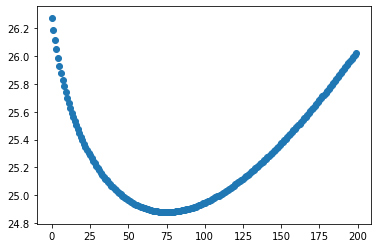

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.scatter(alphas, mses);

### What's the intuition? What are we doing?

The `alpha` parameter corresponds to the weight being given to the extra penalty being calculated by [Tikhonov regularization](https://en.wikipedia.org/wiki/Tikhonov_regularization) (this parameter is sometimes referred to as $\lambda$ in the context of ridge regression).

Normal linear regression (OLS) minimizes the **sum of square error of the residuals**.

Ridge regression minimizes the **sum of square error of the residuals** *AND* **the squared slope of the fit model, times the alpha parameter**.

This is why the MSE for the first model in the for loop (`alpha=0`) is the same as the MSE for linear regression - it's the same model!

As `alpha` is increased, we give more and more penalty to a steep slope. In two or three dimensions this is fairly easy to visualize - beyond, think of it as penalizing coefficient size. Each coefficient represents the slope of an individual dimension (feature) of the model, so ridge regression is just squaring and summing those.

So while `alpha=0` reduces to OLS, as `alpha` approaches infinity eventually the penalty gets so extreme that the model will always output every coefficient as 0 (any non-zero coefficient resulting in a penalty that outweighs whatever improvement in the residuals), and just fit a flat model with intercept at the mean of the dependent variable.

Of course, what we want is somewhere in-between these extremes. Intuitively, what we want to do is apply an appropriate "cost" or penalty to the model for fitting parameters, much like adjusted $R^2$ takes into account the cost of adding complexity to a model. What exactly is an appropriate penalty will vary, so you'll have to put on your model comparison hat and give it a go!

PS - scaling the data helps, as that way this cost is consistent and can be added uniformly across features, and it is simpler to search for the `alpha` parameter.

### Bonus - magic! ✨

Ridge regression doesn't just reduce overfitting and help with the third aspect of well-posed problems (poor generalizability). It can also fix the first two (no unique solution)!

In [29]:
df_tiny = df.sample(10, random_state=27)
print(df_tiny.shape)
X = df_tiny.drop('Price', axis='columns')
y = df_tiny.Price

lin_reg = LinearRegression().fit(X, y)
lin_reg.score(X, y)  # Perfect multi-collinearity!
# NOTE - True OLS would 💥 here
# scikit protects us from actual error, but still gives a poor model

(10, 14)


1.0

In [30]:
ridge_reg = Ridge().fit(X, y)
ridge_reg.score(X, y)  # More plausible (not "perfect")

0.9760119331942763

In [31]:
# Using our earlier test split
mean_squared_error(y_test, lin_reg.predict(X_test))

103.04429449784261

In [32]:
# Ridge generalizes *way* better (and we've not even tuned alpha)
mean_squared_error(y_test, ridge_reg.predict(X_test))

41.79869373639458

### And a bit more math

The regularization used by Ridge Regression is also known as **$L^2$ regularization**, due to the squaring of the slopes being summed. This corresponds to [$L^2$ space](https://en.wikipedia.org/wiki/Square-integrable_function), a metric space of square-integrable functions that generally measure what we intuitively think of as "distance" (at least, on a plane) - what is referred to as Euclidean distance.

The other famous norm is $L^1$, also known as [taxicab geometry](https://en.wikipedia.org/wiki/Taxicab_geometry), because it follows the "grid" to measure distance like a car driving around city blocks (rather than going directly like $L^2$). When referred to as a distance this is called "Manhattan distance", and can be used for regularization (see [LASSO](https://en.wikipedia.org/wiki/Lasso_(statistics%29), which [uses the $L^1$ norm](https://www.quora.com/What-is-the-difference-between-L1-and-L2-regularization-How-does-it-solve-the-problem-of-overfitting-Which-regularizer-to-use-and-when)).

All this comes down to - regularization means increasing model bias by "watering down" coefficients with a penalty typically based on some sort of distance metric, and thus reducing variance (overfitting the model to the noise in the data). It gives us another lever to try and another tool for our toolchest!

### Putting it all together - one last example

The official scikit-learn documentation has many excellent examples - [this one](https://scikit-learn.org/stable/auto_examples/linear_model/plot_ols_ridge_variance.html#sphx-glr-auto-examples-linear-model-plot-ols-ridge-variance-py) illustrates how ridge regression effectively reduces the variance, again by increasing the bias, penalizing coefficients to reduce the effectiveness of features (but also the impact of noise).

Due to the few points in each dimension and the straight line that linear regression uses to follow these points as well as it can, noise on the observations will cause great variance as shown in the first plot. Every line’s slope can vary quite a bit for each prediction due to the noise induced in the observations.

Ridge regression is basically minimizing a penalised version of the least-squared function. The penalising shrinks the value of the regression coefficients. Despite the few data points in each dimension, the slope of the prediction is much more stable and the variance in the line itself is greatly reduced, in comparison to that of the standard linear regression

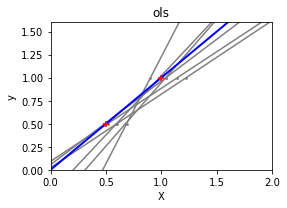

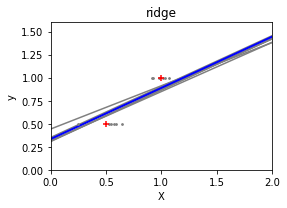

In [33]:
# Code source: Gaël Varoquaux
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause


import numpy as np
import matplotlib.pyplot as plt

from sklearn import linear_model

X_train = np.c_[.5, 1].T
y_train = [.5, 1]
X_test = np.c_[0, 2].T

np.random.seed(0)

classifiers = dict(ols=linear_model.LinearRegression(),
                   ridge=linear_model.Ridge(alpha=.1))

for name, clf in classifiers.items():
    fig, ax = plt.subplots(figsize=(4, 3))

    for _ in range(6):
        this_X = .1 * np.random.normal(size=(2, 1)) + X_train
        clf.fit(this_X, y_train)

        ax.plot(X_test, clf.predict(X_test), color='gray')
        ax.scatter(this_X, y_train, s=3, c='gray', marker='o', zorder=10)

    clf.fit(X_train, y_train)
    ax.plot(X_test, clf.predict(X_test), linewidth=2, color='blue')
    ax.scatter(X_train, y_train, s=30, c='red', marker='+', zorder=10)

    ax.set_title(name)
    ax.set_xlim(0, 2)
    ax.set_ylim((0, 1.6))
    ax.set_xlabel('X')
    ax.set_ylabel('y')

    fig.tight_layout()

plt.show()

## Challenge

In your assignment, you will fit a Ridge Regression model. You can try Linear Regression too — depending on how many features you select, your errors will probably blow up!

---
---

# Review

For your assignment, we're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

Instead, predict property sales prices for **One Family Dwellings** (`BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'`). 

Use a subset of the data where the **sale price was more than \\$100 thousand and less than $2 million.** 

You'll practice all of the module's objectives to build your best model yet!

# Sources

Resources:
- https://www.quora.com/What-is-regularization-in-machine-learning
- https://blogs.sas.com/content/subconsciousmusings/2017/07/06/how-to-use-regularization-to-prevent-model-overfitting/
- https://machinelearningmastery.com/introduction-to-regularization-to-reduce-overfitting-and-improve-generalization-error/
- https://towardsdatascience.com/ridge-and-lasso-regression-a-complete-guide-with-python-scikit-learn-e20e34bcbf0b
- https://stats.stackexchange.com/questions/111017/question-about-standardizing-in-ridge-regression#111022